# CSCE 5210: Project 3

## Name: Rubayet Kabir Tonmoy, ID: 11800754

## Name: Mohammad Jayed Barek, ID: 11814532

# Answer For Question:R1

### Let us first visualize the environment which the agent will learn to navigate. It will be a $5 \times 5$ grid, which we will implement as an adjacency matrix with the help of **`networkx`**.

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Initial Environment In Grid Space




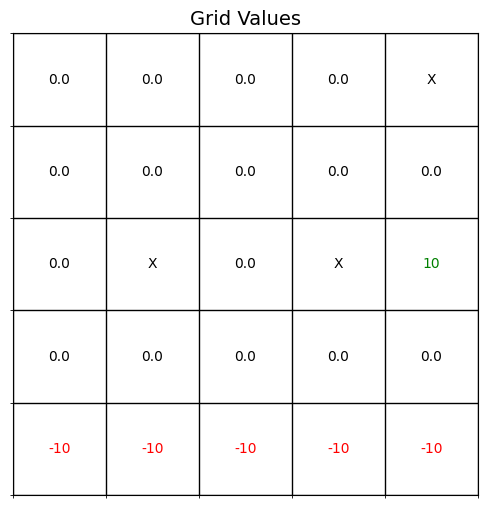



The Graph depicting possible movements by the learning agent


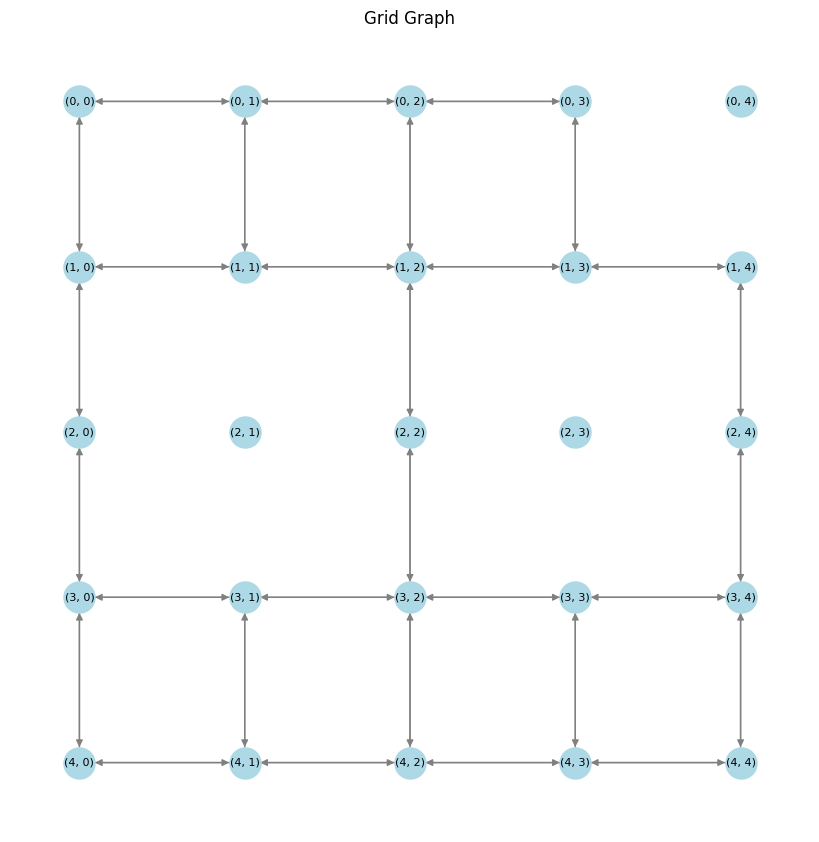

In [29]:
# Define grid dimensions and constants
GRID_SIZE = 5
NOISE = 0.1
REWARDS = {
    "goal": 10,
    "hazard": -10,
    "obstacle": None
}

# Goal position (row, column)
goal_position = (2, 4)
# Bottom row hazards
hazard_positions = [(4, i) for i in range(GRID_SIZE)]
# Obstacles
obstacle_positions = [(2, 1), (2, 3), (0, 4)]


def to_node_index(row, col):
  # Convert grid position (row, col) to a unique node index
  return row * GRID_SIZE + col


def to_grid_position(node_index):
  # Convert node index back to grid position
  return divmod(node_index, GRID_SIZE)


def create_grid_graph():
  # Directed graph to represent transition probabilities
  G = nx.DiGraph()

  # Add nodes
  for row in range(GRID_SIZE):
      for col in range(GRID_SIZE):
          G.add_node((row, col))

  # Add edges with transition probabilities
  for row in range(GRID_SIZE):
      for col in range(GRID_SIZE):
          if (row, col) in obstacle_positions:
              continue

          # Define possible actions and transitions
          actions = {
              "up": (row - 1, col),
              "down": (row + 1, col),
              "left": (row, col - 1),
              "right": (row, col + 1)
          }

          for action, (new_row, new_col) in actions.items():
              if 0 <= new_row < GRID_SIZE and 0 <= new_col < GRID_SIZE:
                  if (new_row, new_col) not in obstacle_positions:
                      intended_prob = 1 - NOISE
                      noisy_prob = NOISE / 2

                      # Add edges with probabilities
                      G.add_edge((row, col), (new_row, new_col), weight=intended_prob if action == "up" else noisy_prob)

  return G


def adjacency_matrix_from_graph(G):
  # Create an adjacency matrix from the graph
  return nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).todense()


def initialize_rewards():
  # Initialize the rewards for all grid nodes
  rewards = {}
  for row in range(GRID_SIZE):
      for col in range(GRID_SIZE):
          if (row, col) == goal_position:
              rewards[(row, col)] = REWARDS["goal"]
          elif (row, col) in hazard_positions:
              rewards[(row, col)] = REWARDS["hazard"]
          elif (row, col) in obstacle_positions:
              # Obstacles are unreachable
              rewards[(row, col)] = -np.inf
          else:
              rewards[(row, col)] = 0
  return rewards


def visualize_grid(values):
  # Visualize the grid with computed values
  grid_values = values.reshape(GRID_SIZE, GRID_SIZE)
  fig, ax = plt.subplots(figsize=(6, 6))
  ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
  ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
  ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
  ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

  for row in range(GRID_SIZE):
      for col in range(GRID_SIZE):
          value = grid_values[row, col]
          cell_text = ""
          text_color = "black"
          if (row, col) == goal_position:
              cell_text = "10"
              text_color = "green"
          elif (row, col) in hazard_positions:
              cell_text = "-10"
              text_color = "red"
          elif (row, col) in obstacle_positions:
              cell_text = "X"
              text_color = "black"
          else:
              cell_text = f"{value:.1f}"

          ax.text(
              col, GRID_SIZE - row - 1, cell_text,
              ha="center", va="center", fontsize=10, color=text_color
          )

  plt.title("Grid Values", fontsize=14)
  plt.show()


def visualize_graph(G):
  # Visualize the grid graph
  pos = {(row, col): (col, -row) for row, col in G.nodes()}
  plt.figure(figsize=(8, 8))
  nx.draw(
      G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8,
      edge_color="gray", arrowsize=10, arrowstyle="-|>"
  )
  plt.title("Grid Graph")
  plt.show()


G = create_grid_graph()
adj_matrix = adjacency_matrix_from_graph(G)
rewards = initialize_rewards()

# Placeholder for grid values to visualize grid
dummy_values = np.zeros(GRID_SIZE * GRID_SIZE)

# Visualize the grid and the graph
print("Initial Environment In Grid Space")
print("\n")
visualize_grid(dummy_values)
print("\n")
print("The Graph depicting possible movements by the learning agent")
visualize_graph(G)

## Code For R1

In [31]:
# Constants
GRID_SIZE = 5
DISCOUNT_FACTOR = 0.99
NOISE = 0.1
MAX_ITERATIONS = 1000
CONVERGENCE_THRESHOLD = 1e-4
REWARDS = {"goal": 10, "hazard": -10, "obstacle": -np.inf}

# Grid elements
goal_position = (2, 4)
hazard_positions = [(4, i) for i in range(GRID_SIZE)]
obstacle_positions = [(2, 1), (2, 3), (0, 4)]
actions = ["up", "down", "left", "right"]
DELTA = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}


def initialize_grid_graph():
    # Create the grid as a directed graph using networkx
    G = nx.DiGraph()

    # Add nodes
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            G.add_node((row, col))

    # Add edges with transition probabilities
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            if (row, col) in obstacle_positions:
                continue

            for action, (dr, dc) in DELTA.items():
                intended_row, intended_col = row + dr, col + dc

                # Handle boundaries and obstacles
                if not (0 <= intended_row < GRID_SIZE and 0 <= intended_col < GRID_SIZE) or (intended_row, intended_col) in obstacle_positions:
                    # Stay in the same cell
                    intended_row, intended_col = row, col

                # Add the intended action with 90% probability
                G.add_edge((row, col), (intended_row, intended_col), weight=0.9)

                # Add unintended actions with 10% probability
                for alt_action, (adr, adc) in DELTA.items():
                    if alt_action != action and (adr, adc) != (-dr, -dc):
                        alt_row, alt_col = row + adr, col + adc
                        if not (0 <= alt_row < GRID_SIZE and 0 <= alt_col < GRID_SIZE) or (alt_row, alt_col) in obstacle_positions:
                            # Stay in the same cell
                            alt_row, alt_col = row, col
                        G.add_edge((row, col), (alt_row, alt_col), weight=0.10)
    return G


def initialize_rewards(live_in_reward):
    # Initialize the rewards for all grid nodes
    rewards = np.full((GRID_SIZE, GRID_SIZE), live_in_reward)
    for row, col in hazard_positions:
        rewards[row, col] = REWARDS["hazard"]
    for row, col in obstacle_positions:
        rewards[row, col] = REWARDS["obstacle"]
    rewards[goal_position] = REWARDS["goal"]
    return rewards


def value_iteration(G, live_in_reward, max_iterations=MAX_ITERATIONS, tolerance=CONVERGENCE_THRESHOLD):
    # Perform value iteration using the directed graph
    rewards = initialize_rewards(live_in_reward)
    # Initialize value = 0 for all cells
    values = np.zeros((GRID_SIZE, GRID_SIZE))
    # Initialize policy
    policy = np.full((GRID_SIZE, GRID_SIZE), None)

    for iteration in range(max_iterations):
        new_values = np.copy(values)
        delta = 0

        for node in G.nodes:
            row, col = node
            if (row, col) in obstacle_positions:
                # Skip obstacles
                continue

            best_action_value = float("-inf")
            best_action = None

            # Evaluate all actions
            for action, (dr, dc) in DELTA.items():
                intended_row, intended_col = row + dr, col + dc

                # Handle boundaries and obstacles
                if not (0 <= intended_row < GRID_SIZE and 0 <= intended_col < GRID_SIZE) or (intended_row, intended_col) in obstacle_positions:
                    intended_row, intended_col = row, col

                # Compute action value
                action_value = 0

                # Add contributions from intended action
                action_value += 0.9 * (
                    rewards[intended_row, intended_col]
                    + DISCOUNT_FACTOR * values[intended_row, intended_col]
                )

                # Add contributions from unintended actions
                # 180 degree movement is not allowed, we have 3 possible movements and 2 of them are unintented(5% probability for each)
                for alt_action, (adr, adc) in DELTA.items():
                    if alt_action != action and (adr, adc) != (-dr, -dc): # Not allowing 180 degree movement
                        alt_row, alt_col = row + adr, col + adc
                        if not (0 <= alt_row < GRID_SIZE and 0 <= alt_col < GRID_SIZE) or (alt_row, alt_col) in obstacle_positions:
                            # Stay in the same cell
                            alt_row, alt_col = row, col
                        action_value += 0.05 * (
                            rewards[alt_row, alt_col]
                            + DISCOUNT_FACTOR * values[alt_row, alt_col]
                        )

                # Update best action
                if action_value > best_action_value:
                    best_action_value = action_value
                    best_action = action

            # Update value and policy
            new_values[row, col] = best_action_value
            policy[row, col] = best_action
            delta = max(delta, abs(values[row, col] - best_action_value))

        values = new_values

        if delta < tolerance:
            break

    return values, policy


def visualize_policy(values, policy):
    # Visualize the policy with arrows and value function
    action_to_arrow = {"up": "↑", "down": "↓", "left": "←", "right": "→"}

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            if (row, col) == goal_position:
                ax.text(col, GRID_SIZE - row - 1, "10", ha="center", va="center", color="green", fontsize=12)
            elif (row, col) in hazard_positions:
                ax.text(col, GRID_SIZE - row - 1, "-10", ha="center", va="center", color="red", fontsize=12)
            elif (row, col) in obstacle_positions:
                ax.text(col, GRID_SIZE - row - 1, "X", ha="center", va="center", color="black", fontsize=12)
            else:
                ax.text(col, GRID_SIZE - row - 1, f"{values[row, col]/1000:.3f}", ha="center", va="center", fontsize=8)
                if policy[row, col] is not None:
                    ax.text(col, GRID_SIZE - row - 1 + 0.2, action_to_arrow[policy[row, col]], ha="center", va="center", fontsize=12)

    plt.title("Policy Visualization with Values and Arrows", fontsize=16)
    plt.show()

### b) **Policy Visualization** is given below (we have used both arrow and the grid values for better visualization):

Values:
[[843.52958515 852.80205905 862.10449379 871.45779457   0.        ]
 [850.07316357 860.67956946 870.94569514 881.92687634 892.57544406]
 [840.47147971   0.         861.11235166   0.         893.10097051]
 [847.59801581 858.78891516 869.74743348 881.31487455 892.54357232]
 [837.50787241 848.01588195 858.86271471 870.22931002 880.7967262 ]]

Policy:
['right', 'right', 'right', 'down', None]
['right', 'right', 'right', 'right', 'down']
['up', None, 'up', None, 'left']
['right', 'right', 'right', 'right', 'up']
['up', 'up', 'up', 'up', 'up']

Optimal Live-In Reward: -0.15

Values are divided by 1000 for better visualization


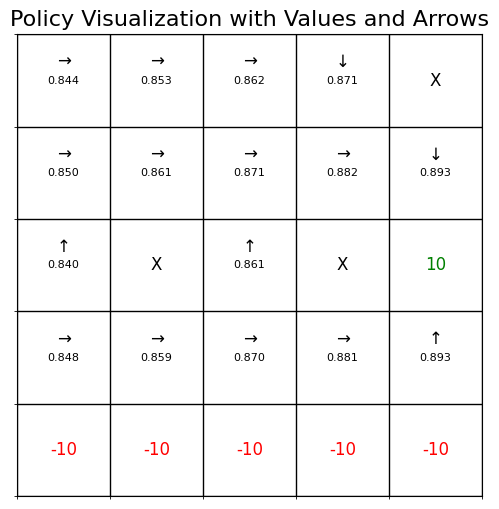

In [32]:
# Main Execution

# Create the grid graph
G = initialize_grid_graph()

# Range of live-in rewards
live_in_rewards = np.arange(-0.3, -0.1, 0.05)
best_live_in_reward = None
best_values = None
best_policy = None
best_score = float("-inf")

# Iterate over different live-in rewards
for live_in_reward in live_in_rewards:
    values, policy = value_iteration(G, live_in_reward)

    # Compute the total value for the grid
    total_value = np.sum(values)

    # Check if this live-in reward produces the best policy
    if total_value > best_score:
        best_score = total_value
        best_live_in_reward = live_in_reward
        best_values = values
        best_policy = policy

# Output the optimal live-in reward and visualize the corresponding policy
print("Values:")
print(best_values)
print("\nPolicy:")
for row in range(GRID_SIZE):
    print([best_policy[row, col] for col in range(GRID_SIZE)])
print(f"\nOptimal Live-In Reward: {best_live_in_reward:.2f}")
print("\nValues are divided by 1000 for better visualization")

visualize_policy(best_values, best_policy)

### The agent in any given grid space will look into it's adjacent cells(including it's previous grid where it traversed from), which are it's possible movements; then it will move to the grid with the highest possible iterative value.

### a) The first  value of **r** in the range `[-3,-1]` that enables us to create the policy $P_1$ is **r = -0.15**.

## Code For R2

In [33]:
# Constants
GRID_SIZE = 5
DISCOUNT_FACTOR = 0.99
NOISE = 0.1
MAX_ITERATIONS = 1000
CONVERGENCE_THRESHOLD = 1e-4
REWARDS = {"goal": 10, "hazard": -10, "obstacle": -np.inf}

# Grid elements
goal_position = (2, 4)
hazard_positions = [(4, i) for i in range(GRID_SIZE)]
obstacle_positions = [(2, 1), (2, 3), (1, 3)]
actions = ["up", "down", "left", "right"]
DELTA = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}


def initialize_grid_graph():
    # Create the grid as a directed graph using networkx
    G = nx.DiGraph()

    # Add nodes
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            G.add_node((row, col))

    # Add edges with transition probabilities
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            if (row, col) in obstacle_positions:
                continue

            for action, (dr, dc) in DELTA.items():
                intended_row, intended_col = row + dr, col + dc

                # Handle boundaries and obstacles
                if not (0 <= intended_row < GRID_SIZE and 0 <= intended_col < GRID_SIZE) or (intended_row, intended_col) in obstacle_positions:
                    # Stay in the same cell
                    intended_row, intended_col = row, col

                # Add the intended action with 90% probability
                G.add_edge((row, col), (intended_row, intended_col), weight=0.9)

                # Add unintended actions with 10% probability each
                for alt_action, (adr, adc) in DELTA.items():
                    if alt_action != action and (adr, adc) != (-dr, -dc): # Not allowing 180 degree movement
                        alt_row, alt_col = row + adr, col + adc
                        if not (0 <= alt_row < GRID_SIZE and 0 <= alt_col < GRID_SIZE) or (alt_row, alt_col) in obstacle_positions:
                            # Stay in the same cell
                            alt_row, alt_col = row, col
                        G.add_edge((row, col), (alt_row, alt_col), weight=0.10)
    return G


def initialize_rewards(live_in_reward):
    # Initialize the rewards for all grid nodes
    rewards = np.full((GRID_SIZE, GRID_SIZE), live_in_reward)
    for row, col in hazard_positions:
        rewards[row, col] = REWARDS["hazard"]
    for row, col in obstacle_positions:
        rewards[row, col] = REWARDS["obstacle"]
    rewards[goal_position] = REWARDS["goal"]
    return rewards


def value_iteration(G, live_in_reward, max_iterations=MAX_ITERATIONS, tolerance=CONVERGENCE_THRESHOLD):
    # Perform value iteration using the directed graph
    rewards = initialize_rewards(live_in_reward)
    # Initialize value = 0 for all cells
    values = np.zeros((GRID_SIZE, GRID_SIZE))
    # Initialize policy
    policy = np.full((GRID_SIZE, GRID_SIZE), None)

    for iteration in range(max_iterations):
        new_values = np.copy(values)
        delta = 0

        for node in G.nodes:
            row, col = node
            if (row, col) in obstacle_positions:
                # Skip obstacles
                continue

            best_action_value = float("-inf")
            best_action = None

            # Evaluate all actions
            for action, (dr, dc) in DELTA.items():
                intended_row, intended_col = row + dr, col + dc

                # Handle boundaries and obstacles
                if not (0 <= intended_row < GRID_SIZE and 0 <= intended_col < GRID_SIZE) or (intended_row, intended_col) in obstacle_positions:
                    intended_row, intended_col = row, col

                # Compute action value
                action_value = 0

                # Add contributions from intended action
                action_value += 0.9 * (
                    rewards[intended_row, intended_col]
                    + DISCOUNT_FACTOR * values[intended_row, intended_col]
                )

                # Add contributions from unintended actions
                # 180 degree movement is not allowed, we have 3 possible movements and 2 of them are unintented(5% probability for each)
                for alt_action, (adr, adc) in DELTA.items():
                    if alt_action != action and (adr, adc) != (-dr, -dc):
                        alt_row, alt_col = row + adr, col + adc
                        if not (0 <= alt_row < GRID_SIZE and 0 <= alt_col < GRID_SIZE) or (alt_row, alt_col) in obstacle_positions:
                            # Stay in the same cell
                            alt_row, alt_col = row, col
                        action_value += 0.05 * (
                            rewards[alt_row, alt_col]
                            + DISCOUNT_FACTOR * values[alt_row, alt_col]
                        )

                # Update best action
                if action_value > best_action_value:
                    best_action_value = action_value
                    best_action = action

            # Update value and policy
            new_values[row, col] = best_action_value
            policy[row, col] = best_action
            delta = max(delta, abs(values[row, col] - best_action_value))

        values = new_values

        if delta < tolerance:
            break

    return values, policy


def visualize_policy(values, policy):
    # Visualize the policy with arrows and value function
    action_to_arrow = {"up": "↑", "down": "↓", "left": "←", "right": "→"}

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)

    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            if (row, col) == goal_position:
                ax.text(col, GRID_SIZE - row - 1, "10", ha="center", va="center", color="green", fontsize=12)
            elif (row, col) in hazard_positions:
                ax.text(col, GRID_SIZE - row - 1, "-10", ha="center", va="center", color="red", fontsize=12)
            elif (row, col) in obstacle_positions:
                ax.text(col, GRID_SIZE - row - 1, "X", ha="center", va="center", color="black", fontsize=12)
            else:
                ax.text(col, GRID_SIZE - row - 1, f"{values[row, col]/1000:.3f}", ha="center", va="center", fontsize=8)
                if policy[row, col] is not None:
                    ax.text(col, GRID_SIZE - row - 1 + 0.2, action_to_arrow[policy[row, col]], ha="center", va="center", fontsize=12)

    plt.title("Policy Visualization with Values and Arrows", fontsize=16)
    plt.show()

Values:
[[844.29000165 854.37654442 864.6424534  875.08574599 885.07591898]
 [836.33398322 845.22961952 854.37654442   0.         895.73322474]
 [840.25098629   0.         862.34496296   0.         895.70260624]
 [849.85019677 861.20468343 872.19214175 883.85571074 895.1146693 ]
 [839.7431653  850.39878743 861.28312098 872.73877542 883.33756239]]

Policy:
['right', 'right', 'right', 'right', 'down']
['right', 'right', 'up', None, 'down']
['down', None, 'down', None, 'left']
['right', 'right', 'right', 'right', 'up']
['up', 'up', 'up', 'up', 'up']

Optimal Live-In Reward: -0.15

Values are divided by 1000 for better visualization


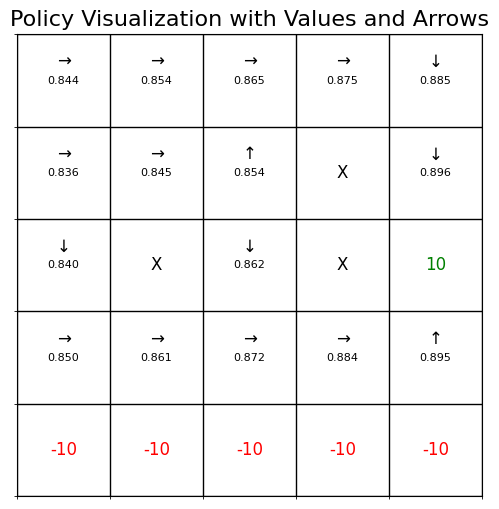

In [34]:
# Main Execution

# Create the grid graph
G = initialize_grid_graph()

# Range of live-in rewards
live_in_rewards = np.arange(-0.3, -0.1, 0.05)
best_live_in_reward = None
best_values = None
best_policy = None
best_score = float("-inf")

# Iterate over different live-in rewards
for live_in_reward in live_in_rewards:
    values, policy = value_iteration(G, live_in_reward)

    # Compute the total value for the grid
    total_value = np.sum(values)

    # Check if this live-in reward produces the best policy
    if total_value > best_score:
        best_score = total_value
        best_live_in_reward = live_in_reward
        best_values = values
        best_policy = policy

# Output the optimal live-in reward and visualize the corresponding policy
print("Values:")
print(best_values)
print("\nPolicy:")
for row in range(GRID_SIZE):
    print([best_policy[row, col] for col in range(GRID_SIZE)])
print(f"\nOptimal Live-In Reward: {best_live_in_reward:.2f}")
print("\nValues are divided by 1000 for better visualization")

visualize_policy(best_values, best_policy)

## R2 Answer
For us the policies $P_1$ and $P_2$ are nearly identical, just some minor changes in policy to avoid the relocated obstacle. \\
Because the policy is dominated by the fundamental dynamics of the environment, including the goal reward **(+10)**, the discount factor **($γ=0.99$)**, and the optimal live-in reward **(-0.15)**, resulting in $P_1$ and $P_2$ being nearly identical. \\

These factors guarantee that minor environmental modifications, such as variations in the positioning of hazards or obstacles, have a negligible effect on the overall optimal behavior. The value iteration algorithm's robustness, which consistently prioritizes the achievement of the objective while avoiding hazards, is also responsible for the similarities. The modest environment is the cause of the minor differences in  $P_1$ and  $P_2$.

## R3 Answer

To adapt the MDP framework for multiple agents in a dynamic environment, we can integrate probabilistic occupancy modeling into the transition dynamics. Each grid point would possess a defined transition probability, determined by noise and planned action, with an occupancy probability indicating the possibility of that position being inhabited by another robot at a specific time. The occupancy probability can be adjusted dynamically according to the established trajectories or behaviors of other agents. \\

In the MDP algorithm, the transition probabilities $P(s'|s,a)$ would be modified to include the probability of a cell being free of other robots. For instance, if a cell has a **90%** chance of being free and a **10%** chance of being occupied, the expected reward for transitioning into that cell would be reduced to reflect the risk of collision. The Bellman equation would then be updated to:

$$ V(s) = max \sum_{s'} P(s'|s,a) \times P_{f}[R(s,a,s') + \gamma V(s')]$$

 Here, $P_{f}(s')$ is the probability that the target cell is unoccupied. This adjustment ensures that the value iteration process accounts for the dynamic nature of the environment, discouraging the agent from moving into cells with high occupancy probabilities. \\

 --> Pseudo Code for Dynamic Transition:
 ```python
 for action in actions:
    # formula for occupancy
    prob_free = compute_occupancy_probability(target_state)  
    action_value += transition_prob * prob_free * (reward + gamma * value_of_target_state)

 ```
 We can now incorporate $P_{f}$ into the Bellman equation to adjust state values during iteration. \\

